Found 10564 images belonging to 4 classes.
Found 2006 images belonging to 4 classes.
✅ Data loaded, starting training...


C:\Users\vedhr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\vedhr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5544 - loss: 1.2196   

C:\Users\vedhr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


331/331 ━━━━━━━━━━━━━━━━━━━━ 979s 3s/step - accuracy: 0.5546 - loss: 1.2191 - val_accuracy: 0.1939 - val_loss: 5.6584 - learning_rate: 1.0000e-04
Epoch 2/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 982s 3s/step - accuracy: 0.6507 - loss: 0.9067 - val_accuracy: 0.8544 - val_loss: 0.4562 - learning_rate: 1.0000e-04
Epoch 3/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 981s 3s/step - accuracy: 0.6858 - loss: 0.8063 - val_accuracy: 0.8016 - val_loss: 0.5242 - learning_rate: 1.0000e-04
Epoch 4/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 982s 3s/step - accuracy: 0.7132 - loss: 0.7161 - val_accuracy: 0.8584 - val_loss: 0.3835 - learning_rate: 1.0000e-04
Epoch 5/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 983s 3s/step - accuracy: 0.7309 - loss: 0.6682 - val_accuracy: 0.8041 - val_loss: 0.5110 - learning_rate: 1.0000e-04
Epoch 6/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 982s 3s/step - accuracy: 0.7419 - loss: 0.6442 - val_accuracy: 0.8395 - val_loss: 0.4317 - learning_rate: 1.0000e-04
Epoch 7/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 982s 3s/step - accuracy: 0.74

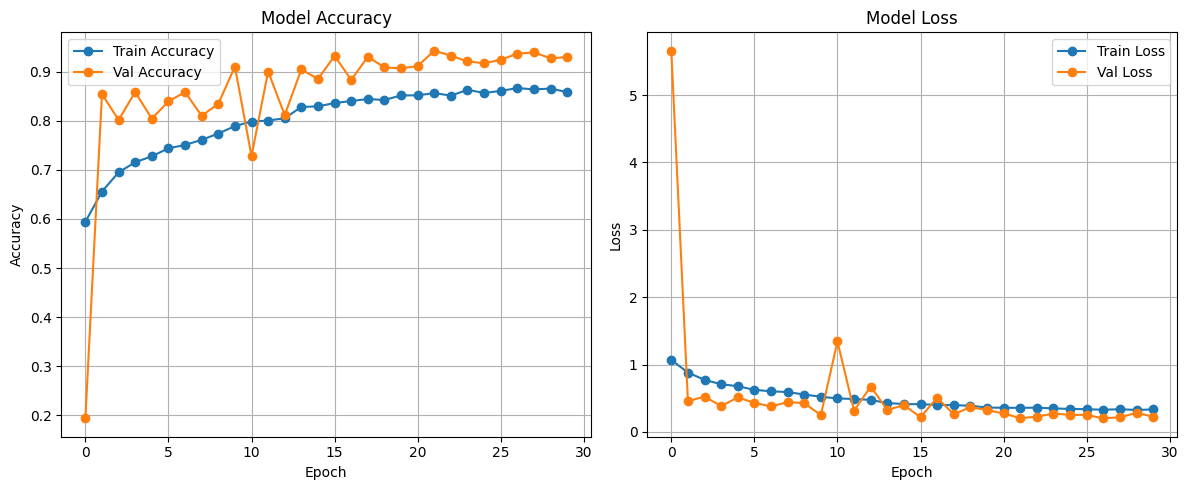

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
IMG_SIZE = 224
BATCH_SIZE = 32 # 16 taking too long
EPOCHS = 30 # 50 is giving nearly same acccuracy as 30 so changed to 30
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest')

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    "brain_tumor_split/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    "brain_tumor_split/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
print(" loading succesful")

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(1e-5)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy')
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr, checkpoint]
)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [4]:
model.save('brain.tumor_V2.keras')
print("saved")

saved


In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
patient is predicted to have: glioma


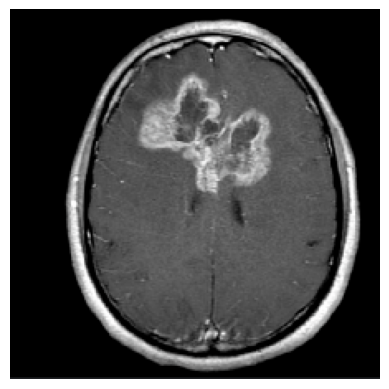

In [21]:
model = load_model("brain.tumor_V2.keras")
img = image.load_img(r"C:\Users\vedhr\OneDrive\Pictures\Screenshots\Screenshot 2025-05-24 182112.png", target_size=(224, 224))
print("patient is predicted to have:", ['glioma', 'healthy', 'meningioma', 'pituitary'][np.argmax(model.predict(np.expand_dims(image.img_to_array(img) / 255.0, 0)))]); plt.imshow(img); plt.axis('off'); plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
patient is predicted to have: meningioma


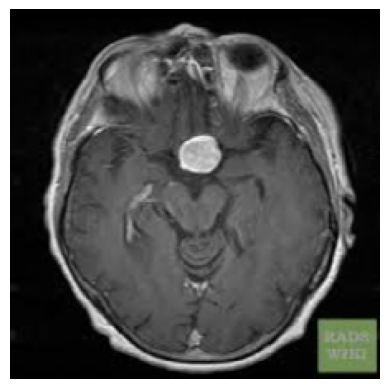

In [22]:
model = load_model("brain.tumor_V2.keras")
img = image.load_img(r"C:\Users\vedhr\OneDrive\Pictures\Screenshots\Screenshot 2025-05-24 185036.png", target_size=(224, 224))
print("patient is predicted to have:", ['glioma', 'healthy', 'meningioma', 'pituitary'][np.argmax(model.predict(np.expand_dims(image.img_to_array(img) / 255.0, 0)))]); plt.imshow(img); plt.axis('off'); plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
patient is predicted to have: healthy


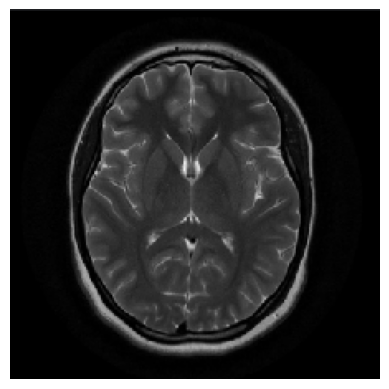

In [23]:
model = load_model("brain.tumor_V2.keras")
img = image.load_img(r"C:\Users\vedhr\OneDrive\Pictures\Screenshots\Screenshot 2025-05-24 185155.png", target_size=(224, 224))
print("patient is predicted to have:", ['glioma', 'healthy', 'meningioma', 'pituitary'][np.argmax(mod el.predict(np.expand_dims(image.img_to_array(img) / 255.0, 0)))]); plt.imshow(img); plt.axis('off'); plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
patient is predicted to have: meningioma


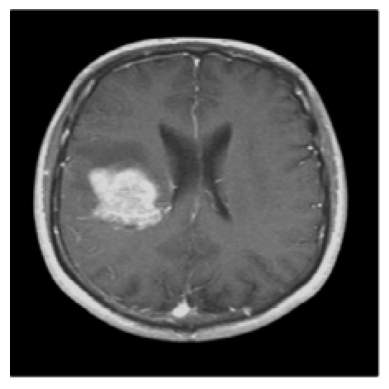

In [25]:
model = load_model("brain.tumor_V2.keras")
img = image.load_img(r"C:\Users\vedhr\OneDrive\Pictures\Screenshots\Screenshot 2025-05-24 163114.png", target_size=(224, 224))
print("patient is predicted to have:", ['glioma', 'healthy', 'meningioma', 'pituitary'][np.argmax(model.predict(np.expand_dims(image.img_to_array(img) / 255.0, 0)))]); plt.imshow(img); plt.axis('off'); plt.show()

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 20,462,606 (78.06 MB)

 Trainable params: 6,820,548 (26.02 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 13,641,098 (52.04 MB)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model = load_model("brain_tumor_classifier.h5")

img = image.load_img("Screenshot 2025-05-23 174354.png", target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

prediction = model.predict(img_array)
class_labels = ['glioma', 'healthy', 'meningioma', 'pituitary']
print("Predicted class:", class_labels[np.argmax(prediction)])

In [ ]:
import splitfolders
splitfolders.fixed("multi_class_dataset",
                   output="brain_tumor_split",
                   seed=42,
                   fixed=(1000, 0, 0)) 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=20,
                               zoom_range=0.2,
                               horizontal_flip=True)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    "brain_tumor_split/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    "brain_tumor_split/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=10)  # 10 epochs giving low accuracy

In [ ]:
model.save('brain_tumor_classifier.h5')